# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
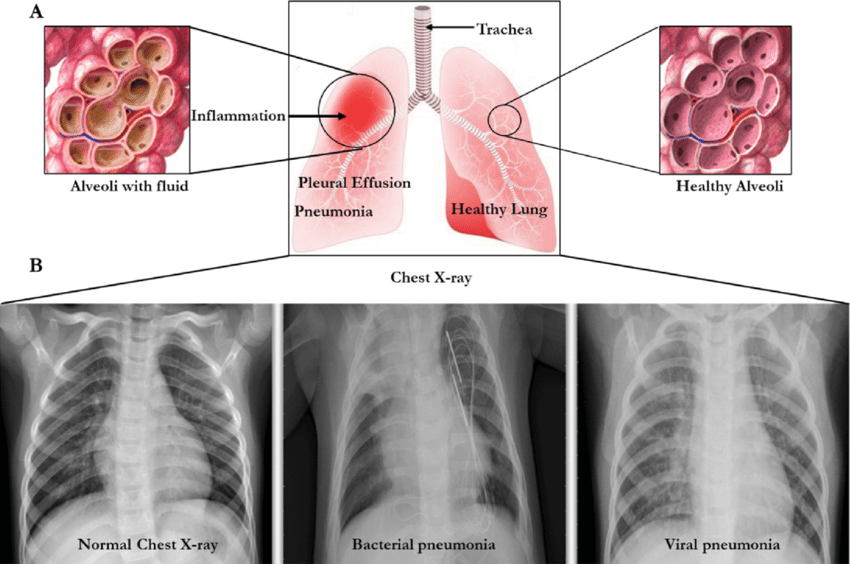

## libraries

In [42]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import cv2
from PIL import Image
import glob as gb
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, BatchNormalization, Dropout, ZeroPadding2D
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
sns.set(rc={'figure.figsize':(15,10)})

# get the data

In [6]:
classes = ['NORMAL', 'PNEUMONIA']
img_size = 227

### Function to get images

In [7]:
def get_images(path):
  data = []
  for label in classes:
    # get all images in this file
    images = gb.glob(pathname=str(path + label + '/*.jpeg'))
    # get the index
    class_num = classes.index(label)
    # loop in all images
    for image in images:
      image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
      # get the width and height of image
      width, height = Image.open(image).size
      # to check if all image could resize
      if width >= 227 and height >= 227:
        resized_img = cv2.resize(image_array, (img_size, img_size))
        data.append([resized_img, class_num])
  return np.array(data)

In [8]:
train = get_images('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
test = get_images('/kaggle/input/chest-xray-pneumonia/chest_xray/test/')
val = get_images('/kaggle/input/chest-xray-pneumonia/chest_xray/val/')

# Get all images and append in one varibale for image and one for label

In [9]:
x = []
y = []

for feature, label in train:
    x.append(feature)
    y.append(label)

for feature, label in test:
    x.append(feature)
    y.append(label)
    
for feature, label in val:
    x.append(feature)
    y.append(label)

# Convert to array and scale

In [10]:
x = np.array(x) / 255

In [11]:
y = np.array(y)

In [12]:
display(x.shape)
y.shape

(5815, 227, 227)

(5815,)

# Reshap data

In [13]:
x = x.reshape(-1, 227, 227, 1)
x.shape

(5815, 227, 227, 1)

## Split data

In [14]:
x_train, xtest, y_train, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [18]:
y_train = np_utils.to_categorical(y_train)

## Model architecture

In [19]:
model = models.Sequential()

model.add(Input(shape=(227, 227, 1)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))



model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation = "softmax"))

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
callback = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.25, verbose=1)]

In [22]:
history = model.fit(x_train, y_train, batch_size=8, epochs=1000, validation_split=0.2, callbacks=callback)

Train on 3721 samples, validate on 931 samples
Epoch 1/1000
3721/3721 [==============================] - 13s 3ms/sample - loss: 1.1767 - accuracy: 0.8562 - val_loss: 6.9557 - val_accuracy: 0.7347
Epoch 2/1000
3721/3721 [==============================] - 8s 2ms/sample - loss: 0.2874 - accuracy: 0.9121 - val_loss: 1.3835 - val_accuracy: 0.5381
Epoch 3/1000
3721/3721 [==============================] - 9s 2ms/sample - loss: 0.2331 - accuracy: 0.9261 - val_loss: 0.3658 - val_accuracy: 0.9184
Epoch 4/1000
3720/3721 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9395
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
3721/3721 [==============================] - 8s 2ms/sample - loss: 0.2004 - accuracy: 0.9395 - val_loss: 0.5607 - val_accuracy: 0.8765
Epoch 5/1000
3721/3721 [==============================] - 8s 2ms/sample - loss: 0.1202 - accuracy: 0.9602 - val_loss: 0.1399 - val_accuracy: 0.9495
Epoch 6/1000
3696/3721 [=====================

# Evaluate data

## loss and accuracy plot

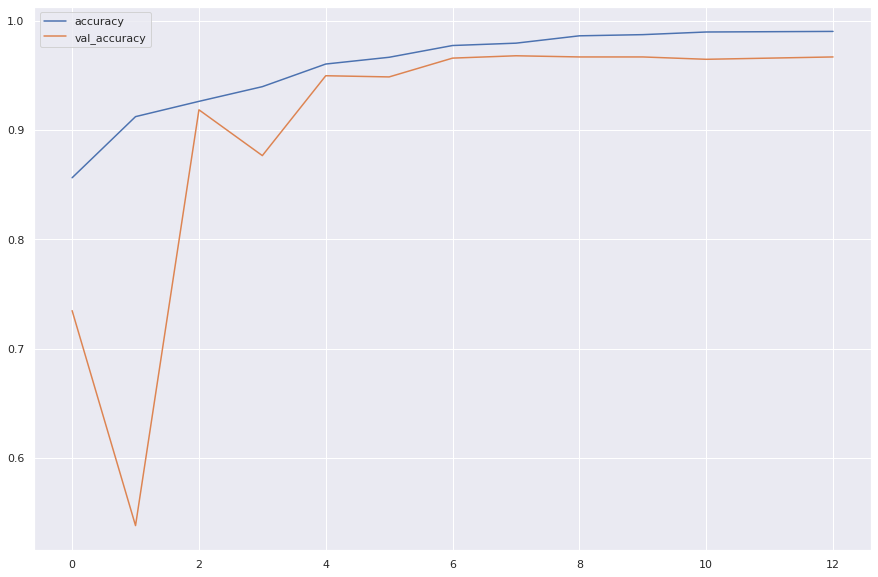

In [23]:
#plot the accuracy
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label='accuracy')
plt.plot(history_df['val_accuracy'], label='val_accuracy')
plt.legend();

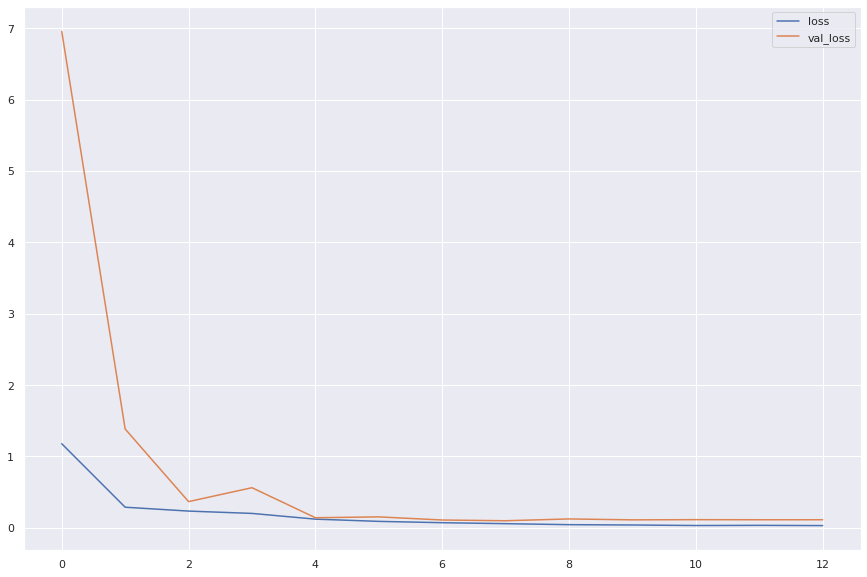

In [24]:
#plot the loss
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.legend();

## Check evalute in train and test data

In [25]:
# Train
loss, acc = model.evaluate(x_train, y_train)
print('Train')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

4652/4652 [==============================] - 3s 644us/sample - loss: 0.0413 - accuracy: 0.9884
Train
loss : 0.04125694948541255
acc : 98.83921146392822


In [26]:
# Test
loss, acc = model.evaluate(xtest, np_utils.to_categorical(ytest))
print('Test')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

1163/1163 [==============================] - 1s 657us/sample - loss: 0.1460 - accuracy: 0.9579
Test
loss : 0.14601927052907845
acc : 95.78675627708435


In [27]:
pred = model.predict(xtest)
pred

array([[9.9900335e-01, 9.9672598e-04],
       [9.9850947e-01, 1.4905382e-03],
       [2.5957517e-12, 1.0000000e+00],
       ...,
       [5.4787097e-06, 9.9999452e-01],
       [1.2263993e-15, 1.0000000e+00],
       [9.9995995e-01, 4.0070303e-05]], dtype=float32)

In [28]:
prediction = np.argmax(pred, axis=-1)
prediction

array([0, 0, 1, ..., 1, 1, 0])

## Confusion matrix

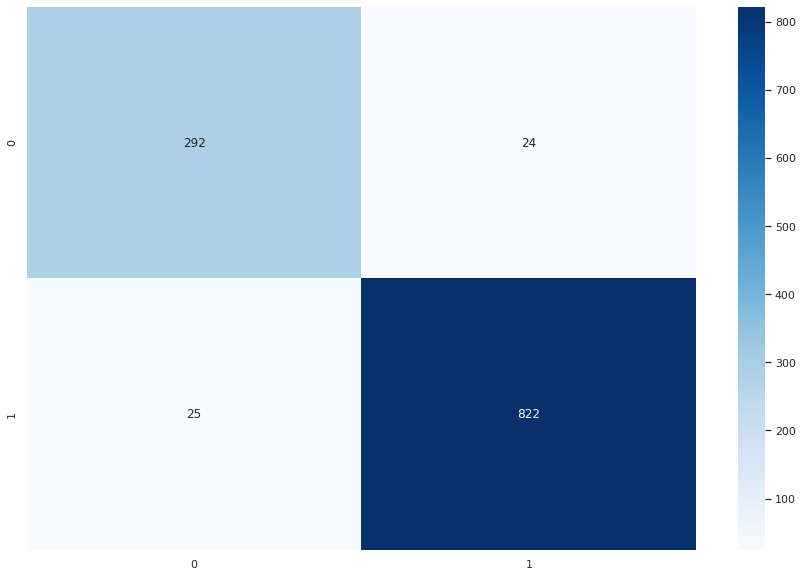

In [38]:
sns.heatmap(confusion_matrix(prediction, ytest), annot=True, fmt='1', cmap='Blues');

## Recall and Precision

In [30]:
print('Model Recall score  : {0:0.4f}'. format(recall_score(ytest, prediction,average='weighted')))
print('Model Precision  : {0:0.4f}'. format(precision_score(ytest, prediction,average='weighted')))

Model Recall score  : 0.9579
Model Precision  : 0.9578


# Right and Wrong prediction

In [31]:
correct = np.nonzero(prediction == ytest)[0]
incorrect = np.nonzero(prediction != ytest)[0]

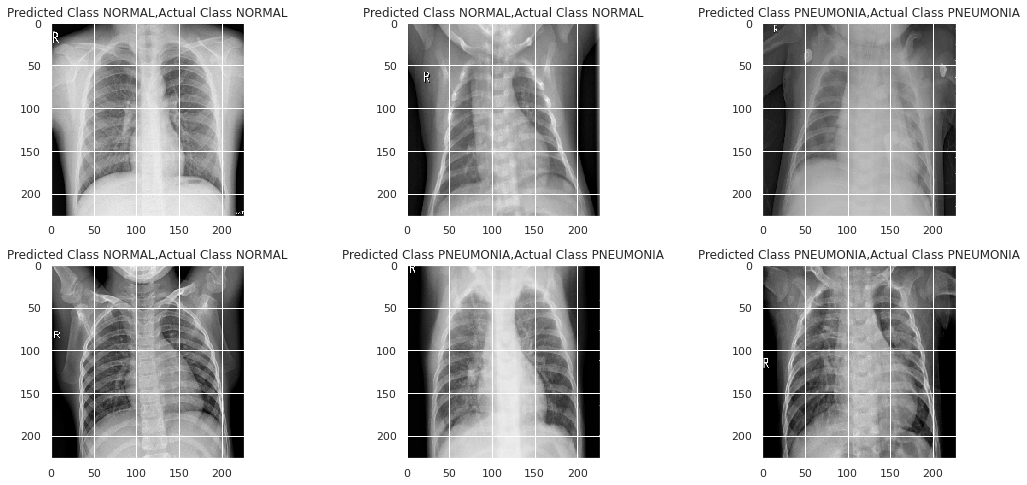

In [32]:
i = 0
for c in correct[:6]:
    plt.subplot(3,3,i+1)
    plt.imshow(xtest[c].reshape(227,227), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(classes[prediction[c]], classes[ytest[c]]))
    plt.tight_layout()
    i += 1

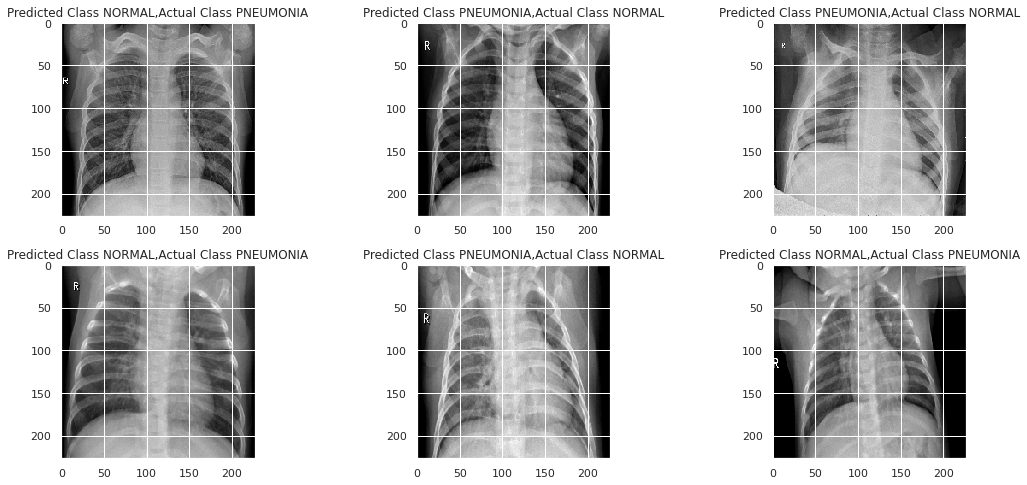

In [39]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,3,i+1)
    plt.imshow(xtest[c].reshape(227,227), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(classes[prediction[c]], classes[ytest[c]]))
    plt.tight_layout()
    i += 1

# Save the model

In [34]:
model.save('CNN_V4.h5')

# Check the saved model

In [65]:
class_names = ['pneumonia', 'normal']
saved_model = load_model("/kaggle/working/CNN_V4.h5", compile=False)
img_arr = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg', cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (227, 227))
resized_arr = np.array(resized_arr) / 255
resized_arr = resized_arr.reshape(-1, 227, 227, 1)
predictions = saved_model.predict(resized_arr)
predicted_class_index = np.argmax(predictions, axis=1)
positive_class_confidence = predictions[0][0]
negative_class_confidence = 1 - positive_class_confidence
print(f"Predicted class: {predicted_class_index}, pneumonia confidence: {negative_class_confidence}, normal confidence: {positive_class_confidence}")


Predicted class: [1], pneumonia confidence: 0.9961909670382738, normal confidence: 0.0038090329617261887


In [59]:
class_names = ['pneumonia', 'normal']
saved_model = load_model("/kaggle/working/CNN_V4.h5", compile=False)
img_arr = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg', cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (227, 227))
resized_arr = np.array(resized_arr) / 255
resized_arr = resized_arr.reshape(-1, 227, 227, 1)
predictions = saved_model.predict(resized_arr)
prediction = np.argmax(predictions, axis=-1)
prediction

array([1])